Нотбук, в котором будет оцениваться качество определения местоположения в случае, когда круговая диаграмма агента строится по "идеальным" данным, а круговые диаграммы для изображения - по предсказаниям.

In [47]:
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model

In [141]:
import sys
sys.path.append('..')
from rectangles_drawing import calculate_one_pixels_diffs
from osm_object import Image_OSM_object

from circle_diagram import calculate_sectors_count, create_circle_diagram
from circle_diagram import Image_circle_diagrams

In [36]:
H, W = 300, 400

one_pixel_lat_diff, one_pixel_lon_diff = calculate_one_pixels_diffs(right_top_lat, right_top_lon, 
                                                                    left_bottom_lat, left_bottom_lon, (H, W))
print(one_pixel_lat_diff, one_pixel_lon_diff)

0.0011630347185021962 0.0013732283464566919


In [3]:
def read_pickle(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)
    
def dump_pickle(filepath, obj):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

In [16]:
THRESH_WOOD = 0.15
THRESH_WATER = 0.15
THRESH_PEAK = 0.08

## 1. Нужно предсказать и сохранить все маски

Тестовые картинки.

In [4]:
train_val_test = read_pickle("../dataset/train_val_test_split.pickle")
test_ids = train_val_test['test']

# берём, как и в случае с ideal_quality_asessment.ipynb только первые 100
test_ids = test_ids[:100]

In [5]:
print(test_ids[:5])

['20327', '9501', '3138', '7130', '10196']


Сначала посмотрим, в каком формате нужно сохранить результаты получения масок.

In [37]:
img_shape = (H, W)

corners_folder = '../dataset/corners'
tags_folder = '../dataset/tags'
bounds_folder = '../dataset/objects'

satellites_folder = '../dataset/satellite'

In [9]:
filename = test_ids[0]

filename_img = filename + '.png'
filename_pickle = filename + '.pickle'

corners = read_pickle(os.path.join(corners_folder, filename_pickle))
tags = read_pickle(os.path.join(tags_folder, filename_pickle))
bounds = read_pickle(os.path.join(bounds_folder, filename_pickle))

right_top_lat = corners['right_top_lat']
right_top_lon = corners['right_top_lon']
left_bottom_lat = corners['left_bottom_lat']
left_bottom_lon = corners['left_bottom_lon']

In [10]:
tags

['peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak',
 'peak']

In [11]:
bounds

[{'maxlon': 45.48593591338583,
  'minlat': 31.835190895844494,
  'minlon': 45.47495008661417,
  'maxlat': 31.842169104155506},
 {'maxlon': 45.40584391338583,
  'minlat': 31.814561895844495,
  'minlon': 45.39999999999999,
  'maxlat': 31.821540104155506},
 {'maxlon': 45.53378611338583,
  'minlat': 32.047306595844496,
  'minlon': 45.52280028661417,
  'maxlat': 32.05428480415551},
 {'maxlon': 45.44862491338583,
  'minlat': 32.122818895844496,
  'minlon': 45.43763908661417,
  'maxlat': 32.12979710415551},
 {'maxlon': 45.41150291338583,
  'minlat': 32.10160389584449,
  'minlon': 45.40051708661417,
  'maxlat': 32.1085821041555},
 {'maxlon': 45.440134913385826,
  'minlat': 32.06634589584449,
  'minlon': 45.42914908661417,
  'maxlat': 32.0733241041555},
 {'maxlon': 45.410764913385826,
  'minlat': 32.03746289584449,
  'minlon': 45.39999999999999,
  'maxlat': 32.0444411041555},
 {'maxlon': 45.51564591338583,
  'minlat': 32.0581318958445,
  'minlon': 45.50466008661417,
  'maxlat': 32.0651101041555

In [12]:
corners

{'left_bottom_lon': 45.39999999999999,
 'left_bottom_lat': 31.799999999999994,
 'right_top_lon': 45.94929133858267,
 'right_top_lat': 32.14891041555065}

Нужно будет приводить границы в пикселях к границам в значениях широты и долготы.

Попробуем для одной картинки.

In [43]:
predictions_folder = '../dataset/predictions/'
raw_predicts_folder = 'raw_predicts_img'
rectangled_predicts_folder = 'rectangled_predicts_pixel'
objects_predicts_folder = 'rectangled_predicts_obj'  # {objects, tags}
predicts_osm_folder = 'predicts_osm'

wood_filename = 'wood'
water_filename = 'water'
peak_filename = 'peak'

In [26]:
def predict_one(autoencoder, img, thresh):
    return autoencoder.predict(np.array([img / 255.]).reshape(([1] + list(img.shape))))[0] >= thresh


def mask_to_rectangles(mask):
    visited = np.zeros(mask.shape[:2], dtype=int)
    queue = []
    rectangles = []
    
    queue_idx = 0

    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            # первая непосещённая вершина
            if visited[x][y] == 0 and mask[x][y]:
                cur_vertex = (x, y)
            else:
                continue
        
            queue.append(cur_vertex)
        
            def bfs(queue_idx):
                min_x, max_x, min_y, max_y = None, None, None, None

                while len(queue) != queue_idx:
                    v = queue[queue_idx]
                    queue_idx += 1

                    x, y = v
                    if visited[x][y] == 1:
                        continue
                    visited[x][y] = 1

                    if min_x is None or x < min_x:
                        min_x = x
                    if max_x is None or x > max_x:
                        max_x = x
                    if min_y is None or y < min_y:
                        min_y = y
                    if max_y is None or y > max_y:
                        max_y = y

                    # рассматриваем все соседние непосещённые вершины
                    left = (x, y - 1)
                    right = (x, y + 1)
                    top = (x - 1, y)
                    bottom = (x + 1, y)

                    def visit_vertex(x, y):
                        if x >= 0 and y >= 0 and x < mask.shape[0] and y < mask.shape[1] and visited[x][y] == 0\
                            and mask[x][y]:
                                queue.append((x, y))

                    visit_vertex(*left)
                    visit_vertex(*right)
                    visit_vertex(*top)
                    visit_vertex(*bottom)

                return queue_idx, queue, visited, min_x, max_x, min_y, max_y

            queue_idx, queue, visited, min_x, max_x, min_y, max_y = bfs(queue_idx)
            if min_x is not None and max_x is not None and min_y is not None and max_y is not None:
                rectangles.append((min_x, max_x, min_y, max_y))

    return rectangles


In [49]:
def rectangle_to_coords(rectangle, right_top_lat, left_bottom_lon):
    x1, x2, y1, y2 = rectangle
    
    minlat = right_top_lat - (x2 * one_pixel_lat_diff)
    maxlat = right_top_lat - (x1 * one_pixel_lat_diff)
    minlon = left_bottom_lon + (y1 * one_pixel_lon_diff)
    maxlon = left_bottom_lon + (y2 * one_pixel_lon_diff)
    
    return minlat, maxlat, minlon, maxlon

In [50]:
def predict_one_img(img_id, class_id, autoencoder, thresh, class_name):
    
    filename = img_id

    filename_img = filename + '.png'
    filename_pickle = filename + '.pickle'

    corners = read_pickle(os.path.join(corners_folder, filename_pickle))
    tags = read_pickle(os.path.join(tags_folder, filename_pickle))
    bounds = read_pickle(os.path.join(bounds_folder, filename_pickle))

    right_top_lat = corners['right_top_lat']
    right_top_lon = corners['right_top_lon']
    left_bottom_lat = corners['left_bottom_lat']
    left_bottom_lon = corners['left_bottom_lon']
    
    satellite_img = cv2.imread(os.path.join(satellites_folder, filename_img))
    
    mask_pred = predict_one(autoencoder, satellite_img, thresh)
    
    rectangles = mask_to_rectangles(mask_pred)
    
    bounds = []
    tags = []
    
    # теперь каждый прямоугольник нужно преобразовать в minlat, maxlat, minlon, maxlon
    for r in rectangles:
        minlat, maxlat, minlon, maxlon = rectangle_to_coords(r, right_top_lat, left_bottom_lon)
        bounds.append({'maxlon': maxlon, 'minlat': minlat, 'minlon': minlon, 'maxlat': maxlat})
        tags.append(class_name)
        
    return bounds, tags, mask_pred, rectangles

In [21]:
autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_wood_satellite.h5'))













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [51]:
%%time
bounds, tags, mask_pred, rectangles = predict_one_img(
    test_ids[0],
    class_id=0,
    autoencoder=autoencoder,
    thresh=THRESH_WOOD,
    class_name='wood'
)

CPU times: user 252 ms, sys: 7.33 ms, total: 259 ms
Wall time: 135 ms


In [52]:
print(bounds)
print(tags)
print(rectangles)

[{'maxlon': 45.56616062992125, 'minlat': 32.10471509624757, 'minlon': 45.49887244094487, 'maxlat': 32.14891041555065}, {'maxlon': 45.627955905511804, 'minlat': 32.13611703364713, 'minlon': 45.627955905511804, 'maxlat': 32.13611703364713}, {'maxlon': 45.619716535433064, 'minlat': 32.111693304558585, 'minlon': 45.60598425196849, 'maxlat': 32.1221606170251}]
['wood', 'wood', 'wood']
[(0, 38, 72, 121), (11, 11, 166, 166), (23, 32, 150, 160)]


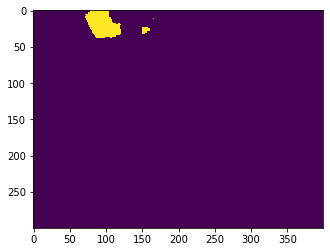

In [54]:
plt.imshow(mask_pred.reshape(img_shape))

In [70]:
print(right_top_lat)
print(right_top_lon)
print(left_bottom_lat)
print(left_bottom_lon)

32.14891041555065
45.94929133858267
31.799999999999994
45.39999999999999


In [77]:
def predict_and_save_one_img(img_id, class_id, autoencoder, thresh, class_name):
    bounds, tags, mask_pred, rectangles = predict_one_img(img_id, class_id, autoencoder, thresh, class_name)
    
    # теперь нужно всё сохранить
    pickle_filename = img_id + '.pickle'
    
    # сырые предикшны (картинка)
    np.save(os.path.join(predictions_folder, raw_predicts_folder, class_name, img_id + '.npy'), mask_pred)
    
    # пиксели предсказанных прямоугольников
    dump_pickle(os.path.join(predictions_folder, rectangled_predicts_folder, class_name, pickle_filename), rectangles)
    
    # objects and tags
    dump_pickle(
        os.path.join(predictions_folder, objects_predicts_folder, class_name, pickle_filename),
        {'objects': bounds, 'tags': tags}
    )
    

In [81]:
autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_wood_satellite.h5'))

In [82]:
%%time
predict_and_save_one_img(test_ids[0], class_id=0, autoencoder=autoencoder, thresh=THRESH_WOOD, class_name='wood')

CPU times: user 566 ms, sys: 24.2 ms, total: 590 ms
Wall time: 383 ms


In [83]:
%%time
for i in range(100):
    predict_and_save_one_img(test_ids[i], class_id=0, autoencoder=autoencoder, thresh=THRESH_WOOD, class_name='wood')

CPU times: user 47.5 s, sys: 837 ms, total: 48.4 s
Wall time: 28.7 s


In [84]:
autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_water_satellite.h5'))

In [85]:
%%time
for i in range(100):
    predict_and_save_one_img(test_ids[i], class_id=1, autoencoder=autoencoder, thresh=THRESH_WATER, class_name='water')

CPU times: user 39.4 s, sys: 742 ms, total: 40.1 s
Wall time: 20.6 s


In [86]:
autoencoder = load_model(os.path.join('AUTOENCODER_MODEL/', 'best_model_peak_satellite.h5'))

In [87]:
%%time
for i in range(100):
    predict_and_save_one_img(test_ids[i], class_id=3, autoencoder=autoencoder, thresh=THRESH_PEAK, class_name='peak')

CPU times: user 37.9 s, sys: 770 ms, total: 38.7 s
Wall time: 19.4 s


Теперь отдельные objects и tags объединим в единые и сохраним в корень

In [127]:
for i in range(100):
    filename = test_ids[i]
    
    pickle_filename = filename + '.pickle'
    
    dict_wood = read_pickle(
        os.path.join(predictions_folder, objects_predicts_folder, 'wood', pickle_filename)
    )
    dict_water = read_pickle(
        os.path.join(predictions_folder, objects_predicts_folder, 'water', pickle_filename)
    )
    dict_peak = read_pickle(
        os.path.join(predictions_folder, objects_predicts_folder, 'peak', pickle_filename)
    )
    objects = dict_wood['objects'] + dict_water['objects'] + dict_peak['objects']
    tags = dict_wood['tags'] + dict_water['tags'] + dict_peak['tags']
    
    dump_pickle(os.path.join(predictions_folder, objects_predicts_folder, pickle_filename), {'objects': objects, 'tags': tags})
    

Получение и сохранение osm. Сначала попробуем для одной картинки

In [128]:
img_id = test_ids[0]

filename = img_id

filename_pickle = filename + '.pickle'

corners = read_pickle(os.path.join(corners_folder, filename_pickle))
objects_and_tags = read_pickle(os.path.join(predictions_folder, objects_predicts_folder, filename_pickle))
tags = objects_and_tags['tags']
bounds = objects_and_tags['objects']

right_top_lat = corners['right_top_lat']
right_top_lon = corners['right_top_lon']
left_bottom_lat = corners['left_bottom_lat']
left_bottom_lon = corners['left_bottom_lon']

In [129]:
print(tags)
print(bounds)

['wood', 'wood', 'wood', 'water', 'water']
[{'maxlon': 45.56616062992125, 'minlat': 32.10471509624757, 'minlon': 45.49887244094487, 'maxlat': 32.14891041555065}, {'maxlon': 45.627955905511804, 'minlat': 32.13611703364713, 'minlon': 45.627955905511804, 'maxlat': 32.13611703364713}, {'maxlon': 45.619716535433064, 'minlat': 32.111693304558585, 'minlon': 45.60598425196849, 'maxlat': 32.1221606170251}, {'maxlon': 45.65816692913385, 'minlat': 32.096573853218054, 'minlon': 45.48788661417322, 'maxlat': 32.14891041555065}, {'maxlon': 45.52496377952755, 'minlat': 32.010509284048894, 'minlon': 45.52496377952755, 'maxlat': 32.017487492359905}]


In [130]:
img_osm = Image_OSM_object(
    img_shape,
    right_top_lat,
    right_top_lon,
    left_bottom_lat,
    left_bottom_lon,
    bounds,
    tags
)

In [131]:
img_osm.osm_objects

In [95]:
img_id

'20327'

In [136]:
osm_object = img_osm.osm_objects[0]
print(osm_object.maxlat)
print(osm_object.minlat)
print(osm_object.maxlon)
print(osm_object.minlon)

0
38
121
72


In [138]:
def calculate_and_save_one_osm_object(img_id):
    filename_pickle = img_id + '.pickle'
    
    corners = read_pickle(os.path.join(corners_folder, filename_pickle))
    objects_and_tags = read_pickle(os.path.join(predictions_folder, objects_predicts_folder, filename_pickle))
    tags = objects_and_tags['tags']
    bounds = objects_and_tags['objects']

    right_top_lat = corners['right_top_lat']
    right_top_lon = corners['right_top_lon']
    left_bottom_lat = corners['left_bottom_lat']
    left_bottom_lon = corners['left_bottom_lon']
    
    img_osm = Image_OSM_object(
        img_shape,
        right_top_lat,
        right_top_lon,
        left_bottom_lat,
        left_bottom_lon,
        bounds,
        tags
    )
    
    dump_pickle(os.path.join(predictions_folder, predicts_osm_folder, filename_pickle), img_osm)

In [139]:
for i in range(100):
    img_id = test_ids[i]
    calculate_and_save_one_osm_object(img_id)

In [140]:
len(os.listdir(os.path.join(predictions_folder, predicts_osm_folder)))

100

## 2. Предсказания и оценки. Полная диаграмма агента, построенная по оригинальным, а не предсказанным данным

#### Построение круговых диаграмм для изображения (данные из предсказанных)

In [142]:
predicts_osm_objects_path = os.path.join(predictions_folder, predicts_osm_folder)

In [151]:
img_id = test_ids[0]
filename_pickle = img_id + '.pickle'

img_osm = read_pickle(os.path.join(predicts_osm_objects_path, filename_pickle))

In [152]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)

img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)

In [153]:
img_osm.osm_objects

In [155]:
len(img_cds.fast_diagrams)

48

In [158]:
img_cds.fast_diagrams[0]

[[(21.931713104248047, 'wood'), (27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.294687271118164, 'wood'), (101.0, 'water')], [(27.29468727111816

#### Построение круговой диаграммы агента для одной точки (для оригинальных данных)

In [159]:
points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')

In [160]:
agent_point = points[0]

In [162]:
orig_osm_objects_path = '../dataset/osm_objects/'

In [163]:
img_osm_for_agent = read_pickle(os.path.join(orig_osm_objects_path, filename_pickle))
img_osm_for_agent.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)

In [164]:
agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm_for_agent)
agent_cd.make_fast()

#### Оценка вероятности попадания в нужный квадрат для одной точки

In [165]:
# аналогично select_minimum_penalty_grid из circle_diagram
def calculate_cells_probs(img_cds, agent_cd):
    """
    only fast version
    """
    penalties = []
    
    for i in range(len(img_cds.center_points)):
        penalties.append(img_cds.fast_diagrams[i].dist_to(agent_cd.fast_diagram))
        
    # Добавл. 1e-8 чтобы не было нулей
    similaryties = np.max(penalties) - penalties + 1e-8

    return similaryties / similaryties.sum()


In [166]:
%%time
cell_probs = calculate_cells_probs(img_cds, agent_cd)

CPU times: user 196 ms, sys: 3.82 ms, total: 200 ms
Wall time: 200 ms


In [167]:
cell_probs

array([2.09353424e-02, 6.59438415e-13, 1.21996107e-03, 1.35551281e-02,
       2.09976175e-02, 2.24428881e-02, 2.26480469e-02, 2.26627015e-02,
       2.15911161e-02, 1.91896649e-02, 1.58759859e-02, 1.94699262e-02,
       2.17486464e-02, 2.22615425e-02, 2.25985890e-02, 2.26553742e-02,
       2.18603855e-02, 2.09536597e-02, 2.05909715e-02, 2.09866326e-02,
       2.19593012e-02, 2.22670385e-02, 2.24868520e-02, 2.26553742e-02,
       2.20252451e-02, 2.19593012e-02, 2.18274146e-02, 2.19757872e-02,
       2.20747030e-02, 2.24373941e-02, 2.24868520e-02, 2.26388883e-02,
       2.23055064e-02, 2.22725345e-02, 2.21076749e-02, 2.22560485e-02,
       2.23055064e-02, 2.24868520e-02, 2.24960106e-02, 2.26462156e-02,
       2.24703660e-02, 2.24373941e-02, 2.24209081e-02, 2.24373941e-02,
       2.24703660e-02, 2.25363098e-02, 2.26352256e-02, 2.26773562e-02])

In [168]:
cell_probs.max()

0.022677356168412294

In [169]:
cell_probs.sum()

1.0

In [170]:
# Теперь нужно найти вероятность попадания в нужный квадрат

In [171]:
def find_center_point_id(center_points, agent_point):
    for i in range(len(center_points)):
        if center_points[i] == agent_point:
            return i

In [172]:
center_point_id = find_center_point_id(img_cds.center_points, points_to_centers[agent_point][::-1])
print(center_point_id)

38


In [173]:
# Вероятность попадания в нужный квадрат
point_prob  = cell_probs[center_point_id]
print(point_prob)

0.02249601060431599


#### Круговая диаграмма агента и оценка вероятности попадания в нужный квадрат для всех точек

In [175]:
predicts_osm_objects_path = os.path.join(predictions_folder, predicts_osm_folder)
orig_osm_objects_path = '../dataset/osm_objects/'

bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)

points = read_pickle('../dataset/100_random_points.pickle')
points_to_centers = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')

In [176]:
def one_point_one_image_prob(img_id, points, points_to_centers):
    filename = str(img_id) + '.pickle'
    
    img_osm = read_pickle(os.path.join(predicts_osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)
    
    img_osm_for_agent = read_pickle(os.path.join(orig_osm_objects_path, filename_pickle))
    img_osm_for_agent.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    
    point_probs = []
    
    for agent_point in points:
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm_for_agent)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers[agent_point][::-1])
        
        point_probs.append(cell_probs[center_point_id])
    return np.array(point_probs).mean()

In [177]:
%%time
one_point_one_image_prob(1, points, points_to_centers)

CPU times: user 26 s, sys: 24.8 ms, total: 26 s
Wall time: 26 s


0.02031628718137562

#### Повторение всех предыдущих пунктов для всех картинок

In [178]:
%%time
img_mean_probs = []

for i in range(len(test_ids)):
    if i % 10 == 0:
        print(i)
    img_mean_probs.append(one_point_one_image_prob(test_ids[i], points, points_to_centers))

0
10
20
30
40
50
60
70
80
90
CPU times: user 44min 5s, sys: 1.37 s, total: 44min 6s
Wall time: 44min 7s


In [179]:
print(img_mean_probs)

[0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.02031628718137562, 0.0203162871

In [180]:
print("Средняя вероятность попадания в нужный квадрат: %.4f" % np.array(img_mean_probs).mean())

Средняя вероятность попадания в нужный квадрат: 0.0203


In [181]:
dump_pickle("../dataset/predicted_means_48cells_6x8.pickle", img_mean_probs)

In [184]:
ideal_img_mean_probs = read_pickle('../dataset/ideal_means_48cells_6x8.pickle')

Сравним распределения.

In [185]:
from scipy import stats

In [186]:
stats.mannwhitneyu(img_mean_probs, ideal_img_mean_probs, alternative='two-sided')

MannwhitneyuResult(statistic=500.0, pvalue=6.488002274992765e-32)

Гипотеза о равенстве распределений на уровне значимости 0.05 уверенно отвергается. 

In [187]:
print("Средняя вероятность попадания в нужный квадрат в идеальном случае: %.4f" % np.array(ideal_img_mean_probs).mean())

Средняя вероятность попадания в нужный квадрат в идеальном случае: 0.0221


Однако в абсолютных значениях разница не выглядит очень большой.

In [199]:
mean_6x8 = np.array(img_mean_probs).mean()
mean_6x8_ideal = np.array(ideal_img_mean_probs).mean()

mean_6x8 / (mean_6x8_ideal / 100)

91.75536471276432

То есть новое среднее составляет 91.75 % (примерно), от предыдущего. А разница:

In [200]:
100 - mean_6x8 / (mean_6x8_ideal / 100)

8.244635287235681

8.25 % то есть. (Потеряли чуть больше 8 % точности)

#### Более крупное разбиение.

In [188]:
bigger_side_blocks_count = 4
sectors_count = calculate_sectors_count(bigger_side_blocks_count)

In [189]:
points_to_centers = read_pickle('../dataset/100_points_to_cell_centers_12cells_3x4.pickle')

In [190]:
%%time
img_mean_probs_3x4 = []

for i in range(len(test_ids)):
    if i % 10 == 0:
        print(i)
    img_mean_probs_3x4.append(one_point_one_image_prob(test_ids[i], points, points_to_centers))

0
10
20
30
40
50
60
70
80
90
CPU times: user 2min 35s, sys: 292 ms, total: 2min 35s
Wall time: 2min 35s


In [191]:
print("Средняя вероятность попадания в нужный квадрат разбиение 3x4: %.4f" % np.array(img_mean_probs_3x4).mean())

Средняя вероятность попадания в нужный квадрат разбиение 3x4: 0.0823


In [192]:
dump_pickle("../dataset/predicted_means_12cells_3x4.pickle", img_mean_probs_3x4)

In [193]:
ideal_img_mean_probs_3x4 = read_pickle('../dataset/ideal_means_12cells_3x4.pickle')

In [194]:
print("Средняя вероятность попадания в нужный квадрат в идеальном случае разбиение 3x4: %.4f" % 
      np.array(ideal_img_mean_probs_3x4).mean())

Средняя вероятность попадания в нужный квадрат в идеальном случае разбиение 3x4: 0.0833


Абсолютно разница примерно на 0.001.

In [195]:
stats.mannwhitneyu(img_mean_probs_3x4, ideal_img_mean_probs_3x4, alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=5.3812607891819794e-40)

И да, это разные распределения.

In [201]:
mean_3x4 = np.array(img_mean_probs_3x4).mean()
mean_3x4_ideal = np.array(ideal_img_mean_probs_3x4).mean()

mean_3x4 / (mean_3x4_ideal / 100)

98.74533202564862

In [202]:
100 - (mean_3x4 / (mean_3x4_ideal / 100))

1.2546679743513778

В этом случае потеряли всего 1.25 % точности, т.е. чуть больше процента.

## 3. В диаграмме агента берём только несколько ближайших объектов.

In [203]:
def cut_sectors(circle_diagram, max_len):
    for i in range(len(circle_diagram.sectors)):
        circle_diagram.sectors[i] = circle_diagram.sectors[i][:max_len]
    return circle_diagram

In [205]:
bigger_side_blocks_count = 8
sectors_count = calculate_sectors_count(bigger_side_blocks_count)


def one_point_one_image_prob_with_cut(img_id, points, points_to_centers):
    filename = str(img_id) + '.pickle'
    
    img_osm = read_pickle(os.path.join(predicts_osm_objects_path, filename_pickle))
    img_osm.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    img_cds = Image_circle_diagrams(img_osm, bigger_side_blocks_count, sectors_count, with_fast=True)
    
    img_osm_for_agent = read_pickle(os.path.join(orig_osm_objects_path, filename_pickle))
    img_osm_for_agent.img_cutted_shape = (img_osm.img_cutted_shape[0], img_osm.img_cutted_shape[1], 3)
    
    point_probs_2 = []
    point_probs_1 = []
    
    for agent_point in points:
        agent_cd = create_circle_diagram(sectors_count, agent_point, img_osm_for_agent)
        
        # max_len = 2
        agent_cd = cut_sectors(agent_cd, max_len=2)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers[agent_point][::-1])
        
        point_probs_2.append(cell_probs[center_point_id])
        
        # max_len = 1
        agent_cd = cut_sectors(agent_cd, max_len=1)
        agent_cd.make_fast()
        
        cell_probs = calculate_cells_probs(img_cds, agent_cd)
        center_point_id = find_center_point_id(img_cds.center_points, points_to_centers[agent_point][::-1])
        
        point_probs_1.append(cell_probs[center_point_id])
        
    return np.array(point_probs_2).mean(), np.array(point_probs_1).mean()

In [206]:
%%time
points_to_centers = read_pickle('../dataset/100_points_to_cell_centers_48cells_6x8.pickle')

img_mean_probs_6x8_max2 = []
img_mean_probs_6x8_max1 = []

for i in range(len(test_ids)):
    if i % 10 == 0:
        print(i)
    max2, max1 = one_point_one_image_prob_with_cut(test_ids[i], points, points_to_centers)
    
    img_mean_probs_6x8_max2.append(max2)
    img_mean_probs_6x8_max1.append(max1)

0
10
20
30
40
50
60
70
80
90
CPU times: user 1h 21min 43s, sys: 2.69 s, total: 1h 21min 45s
Wall time: 1h 21min 45s


In [207]:
dump_pickle('../dataset/predicted_means_48cells_6x8_max2.pickle', img_mean_probs_6x8_max2)
dump_pickle('../dataset/predicted_means_48cells_6x8_max1.pickle', img_mean_probs_6x8_max1)

In [208]:
stats.mannwhitneyu(img_mean_probs, img_mean_probs_6x8_max2, alternative='two-sided')

MannwhitneyuResult(statistic=10000.0, pvalue=3.5216158823946e-45)

In [209]:
stats.mannwhitneyu(img_mean_probs, img_mean_probs_6x8_max1, alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=3.5216158823946e-45)

А тут есть ощущение, что нельзя указать на равенство распределений. Логично ли это? В этом случае вполне логично. Тут явно сразу просвечивает, что то, что вокруг в оригинале не то, что удалось предсказать.

## TODO: (в другом ноутбуке) - ручная разметка и построение диаграммы агента по этой ручной разметке, а диаграммы для изображения по предсказаниям (те osm, что были получены в этом ноутбуке)